In this project on stock market prediction, I plan to train the dataset on the following models.

- Auto ARIMAX<br>
- Facebook Prophet<br>
- LightGBM<br>
- LSTM<br>

- Below, `%reload_ext autoreload` is a magic command in jupyter notebook that enables autoreloading of imported modules in IPython. It allows changes made to a module's code to be immediately reflected in the notebook, without having to manually restart the kernel or reload the module.
- `%autoreload 2` reloads all modules before executing a new line of code.
- `%matplotlib inline` helps to make visualization within the notebook

In [2]:
# INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Getting the required packages 

We first have to install the following packages using pip.
- package `pmdarima` for importing `auto_arima` module to train dataset with Auto ARIMAX model
- prophet for training Facebook Prophet
- lightgbm

In [3]:
#installing packages

#uncomment below if packages are not already installed in your local environment
#!pip install pmdarima
#!pip install lightgbm
#!pip install prophet --no-cache-dir

A `!` mark is needed before `pip` for shell command. If you are installing it in your local machine from command line interface (CLI), then you don't need this exclamation (`!`) mark.  

In [4]:
# importing PACKAGES:

# data analysis
import numpy as np
import pandas as pd

#ML model training
from pmdarima import auto_arima
from prophet import Prophet
import lightgbm as lgb

#evaluation metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import warnings
import itertools
warnings.filterwarnings("ignore")

# 2. Getting the dataset

- For link to the dataset: [Click here](https://www.kaggle.com/datasets/aayushmishra1512/faang-complete-stock-data?select=Netflix.csv).<br>

- Above dataset contains stocks of Apple for about 40 years from 1980 to 2020 

In [6]:
# make sure dataset with -csv extension is there in the directory
!ls

Apple.csv  LICENSE  README.md  stock-market-prediction.ipynb


In [7]:
#1. use read_csv function from pandas libraray to read the dataset 
#2. store contents of the file in a DataFrame object df
df = pd.read_csv("Apple.csv")

In [8]:
#print first 5 rows of the dtatset
df.head()

Date      Open      High       Low     Close  Adj Close       Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261  469033600.0
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978  175884800.0
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934  105728000.0
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   86441600.0
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   73449600.0

In the above dataset, 
- `Date` is in yyyy-mm-dd format
- **Volume**  is the **target variable** to predict. 

## 3. Getting to know the dataset

In [9]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

We see that, all features are numerics except, date. This makes sense. All features have their right datatype.

In [10]:
##Summary Statistics
df.describe().round(2)

Open      High       Low     Close  Adj Close        Volume
count  10015.00  10015.00  10015.00  10015.00   10015.00  1.001500e+04
mean       9.01      9.11      8.92      9.02       8.48  3.413188e+08
std       16.84     17.03     16.68     16.87      16.47  3.426534e+08
min        0.05      0.05      0.05      0.05       0.04  1.388800e+06
25%        0.27      0.28      0.26      0.27       0.23  1.315944e+08
50%        0.44      0.45      0.43      0.44       0.37  2.285380e+08
75%       10.06     10.18      9.89     10.10       8.73  4.250092e+08
max      132.76    134.80    130.53    134.18     134.18  7.421641e+09

In [11]:
# Getting the basic information about the dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10016 non-null  object 
 1   Open       10015 non-null  float64
 2   High       10015 non-null  float64
 3   Low        10015 non-null  float64
 4   Close      10015 non-null  float64
 5   Adj Close  10015 non-null  float64
 6   Volume     10015 non-null  float64
dtypes: float64(6), object(1)
memory usage: 547.9+ KB


In [12]:
df.shape

(10016, 7)

In [13]:
df['Date'].min()

'1980-12-12'

In [14]:
df['Date'].max()

'2020-09-01'

Thus we have have datas for about 40 years in 10k rows.

## 4. formatting the dataset 

#### Making all feature names consistent i.e. all are small letters and spaces are replaced by a underscore `_` 

In [15]:
df.columns  = df.columns.str.lower().str.replace(' ','_')

In [16]:
df.head()

date      open      high       low     close  adj_close       volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261  469033600.0
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978  175884800.0
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934  105728000.0
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   86441600.0
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   73449600.0

We have to change the datatype of `date` feature from `object` to `datetime` before we proceed with any time series analysis. Look into Pandas [time series](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) for these tools.

In [17]:
# Converting the Date column from Object data type to Datetime64 format:
df.date = pd.to_datetime(df.date,format='%Y-%m-%d')

In [18]:
# Getting the basic information after dtype change:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       10016 non-null  datetime64[ns]
 1   open       10015 non-null  float64       
 2   high       10015 non-null  float64       
 3   low        10015 non-null  float64       
 4   close      10015 non-null  float64       
 5   adj_close  10015 non-null  float64       
 6   volume     10015 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 547.9 KB


We see that dtype of `date` is now changed to `datetime64[ns]`.

In [19]:
df.dtypes

date         datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
adj_close           float64
volume              float64
dtype: object

In [20]:
# Getting the sum count of missing values in each column:
df.isnull().sum()

date         0
open         1
high         1
low          1
close        1
adj_close    1
volume       1
dtype: int64

We have very small amount of missing data. We can just neglect them. I will just delete these data

In [21]:
#delete the row with nan values
df.dropna(inplace=True)

In [22]:
df.isna().values.any()

False

In [23]:
df.head()

date      open      high       low     close  adj_close       volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261  469033600.0
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978  175884800.0
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934  105728000.0
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   86441600.0
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   73449600.0

# 3. Splitting the dataset 

**REMEMBER** We don't shuffle data in time-series, because if we shuffle, then the model may know the future data by mistake.

Splitting the data into train, validation and test (60/20/20) along with features.<br>

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
df_full_train, df_test = train_test_split(df, test_size=0.2, shuffle = False)

In [26]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle = False)

In [27]:
df_train.tail()

date      open      high       low     close  adj_close  \
6005 2004-09-28  0.668929  0.683750  0.668750  0.679286   0.586997   
6006 2004-09-29  0.677321  0.693929  0.675357  0.690714   0.596873   
6007 2004-09-30  0.696429  0.701250  0.686607  0.691964   0.597953   
6008 2004-10-01  0.698571  0.699821  0.688929  0.690536   0.596719   
6009 2004-10-04  0.699643  0.699643  0.691964  0.692679   0.598571   

           volume  
6005  353186400.0  
6006  273509600.0  
6007  425012000.0  
6008  465404800.0  
6009  574084000.0

In [28]:
df_val.head()

date      open      high       low     close  adj_close  \
6010 2004-10-05  0.688571  0.708393  0.685714  0.703036   0.607521   
6011 2004-10-06  0.705357  0.727857  0.704821  0.725714   0.627118   
6012 2004-10-07  0.723929  0.730893  0.704643  0.707500   0.611378   
6013 2004-10-08  0.706429  0.710179  0.693571  0.697500   0.602737   
6014 2004-10-11  0.692857  0.697500  0.682143  0.689107   0.595485   

           volume  
6010  406162400.0  
6011  446303200.0  
6012  426148800.0  
6013  359228800.0  
6014  323870400.0

In [29]:
df_val.tail()

date       open       high        low      close  adj_close  \
8008 2012-09-10  24.301786  24.403214  23.646429  23.669285  20.541376   
8009 2012-09-11  23.753929  23.932142  23.446428  23.592501  20.474737   
8010 2012-09-12  23.816071  23.924999  23.428572  23.921072  20.759890   
8011 2012-09-13  24.191786  24.482143  24.098928  24.392143  21.168703   
8012 2012-09-14  24.641428  24.892143  24.567499  24.688572  21.425959   

           volume  
8008  487998000.0  
8009  503983200.0  
8010  712233200.0  
8011  598360000.0  
8012  600474000.0

In [30]:
df_test.head()

date       open       high        low      close  adj_close  \
8013 2012-09-17  24.976786  24.992857  24.807501  24.992144  21.689409   
8014 2012-09-18  24.995714  25.083214  24.872143  25.068214  21.755436   
8015 2012-09-19  25.009285  25.142500  24.984642  25.075001  21.761318   
8016 2012-09-20  24.969999  25.002142  24.772142  24.953571  21.655943   
8017 2012-09-21  25.086071  25.181072  24.977142  25.003214  21.699020   

           volume  
8013  398031200.0  
8014  373503200.0  
8015  326874800.0  
8016  336568400.0  
8017  571589200.0

We see above that splitting is done successfully without splitting.

In [31]:
len(df_train), len(df_val), len(df_test), len(df_full_train),  len(df_train)+len(df_val), len(df_train)+len(df_val)+\
len(df_test), len(df)

(6009, 2003, 2003, 8012, 8012, 10015, 10015)

Above we see that lengths of the dataframes are consistent.

## 4. EDA on training dataset

## Missing value

In [32]:
df_train.head()

date      open      high       low     close  adj_close       volume
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261  469033600.0
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978  175884800.0
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934  105728000.0
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   86441600.0
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   73449600.0

In [33]:
df_train.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

We have negligible number od missing values. We'll neglect them for now.

Let's plot the target variable `volume` over time

<AxesSubplot: >

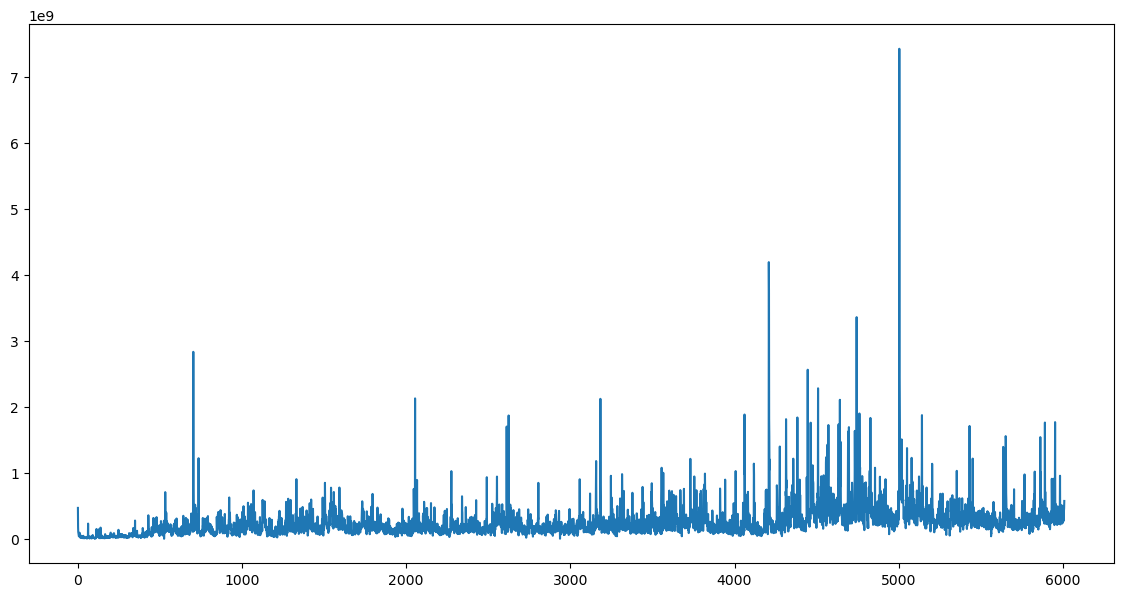

In [34]:
df_train.volume.plot(figsize=(14, 7))

In the above plot X-axis is along indices. It would be better to visualize with date. For this let's change indices into date and then plot again. 

In [35]:
#set the DataFrame's index to the "Date" column
#keep the Date column in the DataFrame
#inplace=True modifies the DataFrame in place instead of returning a new one.
df_train.set_index("date", drop=False, inplace=True)
df_val.set_index("date", drop=False, inplace=True)
df_test.set_index("date", drop=False, inplace=True)
df_full_train.set_index("date", drop=False, inplace=True)
df_train.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0

<AxesSubplot: xlabel='date'>

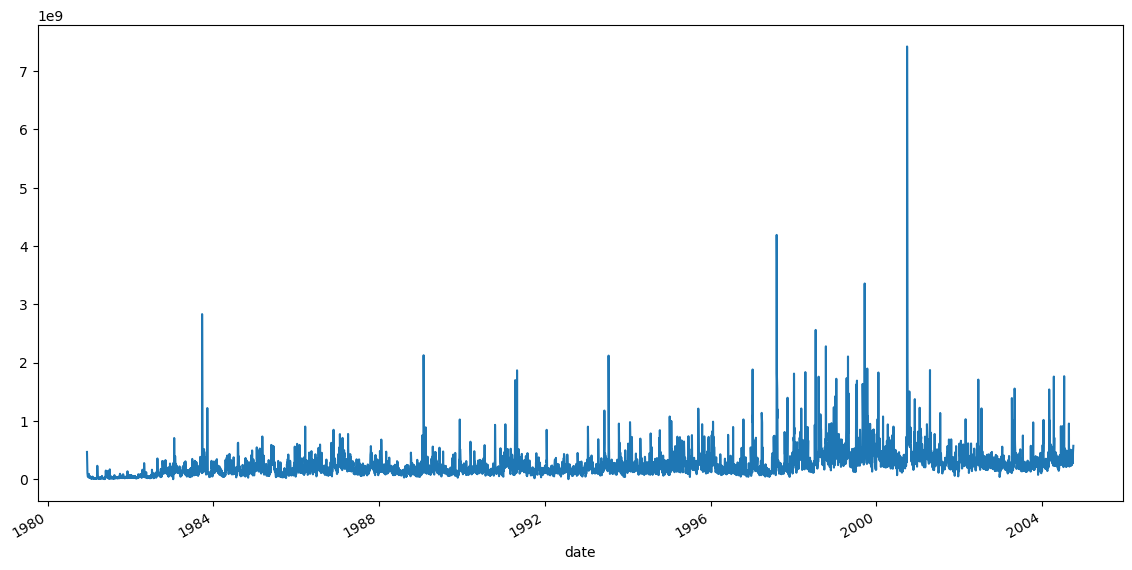

In [36]:
df_train.volume.plot(figsize=(14, 7))

Now our x-axis is along year. We see a very random behavior of volume with time axis here and no clear conclusions can be made here. 

### What is the trend in closing price of stock (adj_close) with time? 

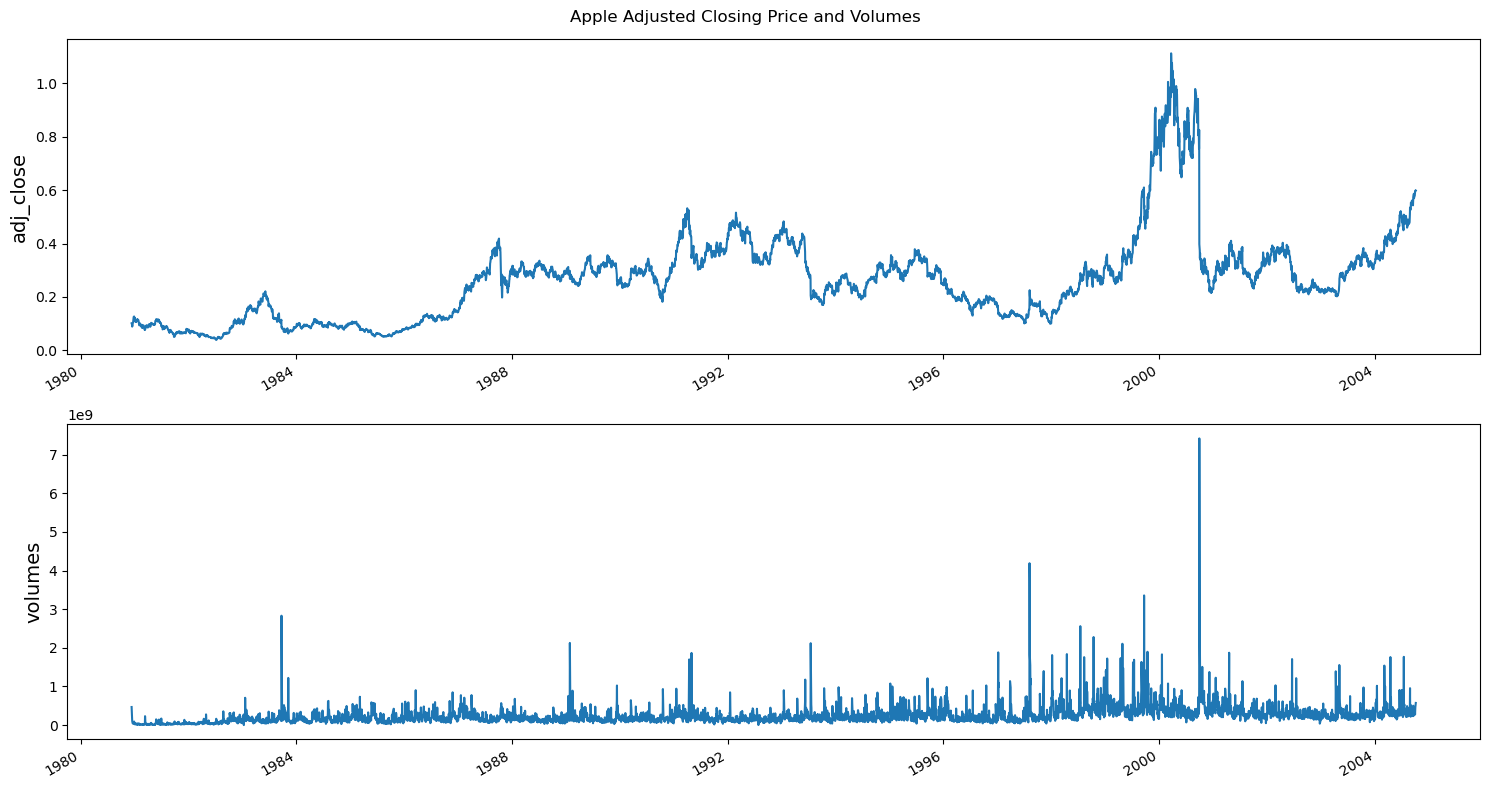

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plotting Apple's adjusted closing price (adj_close):
df_train['adj_close'].plot(ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('adj_close',fontsize=14)

# Creating a line plot for Apple's stock Volumes:
df_train['volume'].plot(ax=axes[1])
axes[1].set_ylabel('volumes', fontsize=14)
axes[1].set_xlabel('')  # to get nothing in x axis as labels

plt.suptitle('Apple Adjusted Closing Price and Volumes')
plt.tight_layout()
plt.show()

We can relate in the above figure that, 
* when closing prices abruptly increases or decreases, this causes a peak in volume i.e. the number of stocks sold or bought that day
* In the period around 2000, there was a peak in Apple's stock prices.

It would be intresting to compare in one plot how `adj_close` and `close` trends. 

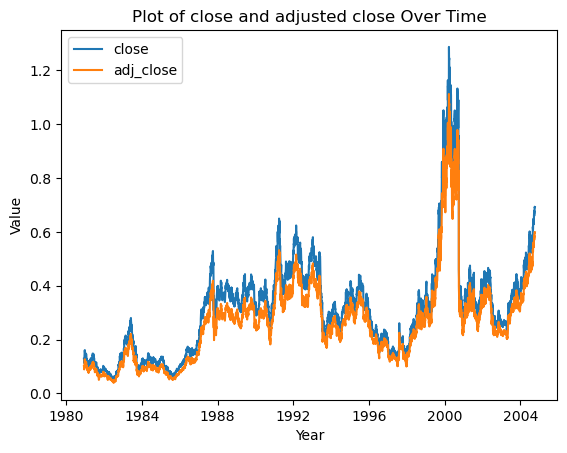

In [38]:
# Plot the columns using matplotlib
plt.plot(df_train.index, df_train['close'], label="close")
plt.plot(df_train.index, df_train['adj_close'], label="adj_close")

# Add a legend, axis labels, and title
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Plot of close and adjusted close Over Time")

# Show the plot
plt.show()

We see in the above figure that close and adjusted close follows the same trend.

Next we'll see how `open` and `close` compared in the same plot. 

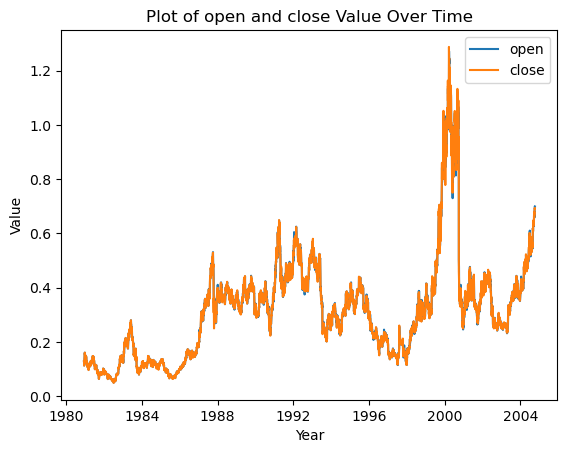

In [39]:
# Plot the columns using matplotlib
plt.plot(df_train.index, df_train['open'], label="open")
plt.plot(df_train.index, df_train['close'], label="close")

# Add a legend, axis labels, and title
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Plot of open and close Value Over Time")

# Show the plot
plt.show()

Open and close are almost indstiguisable at this scale with bare eye.

Now we'll plot open, close, high and low in the same plot.

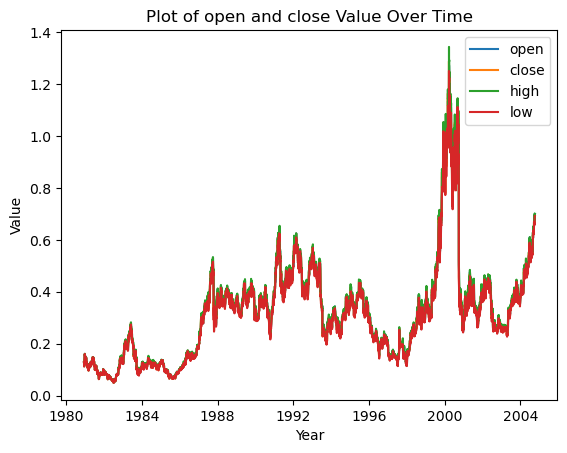

In [40]:
# Plot the columns using matplotlib
plt.plot(df_train.index, df_train['open'], label="open")
plt.plot(df_train.index, df_train['close'], label="close")
plt.plot(df_train.index, df_train['high'], label="high")
plt.plot(df_train.index, df_train['low'], label="low")

# Add a legend, axis labels, and title
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Plot of open and close Value Over Time")

# Show the plot
plt.show()

- Sometimes high in green are visible. All of them folllow the same trend at this scale.

### Moving average of Apple stock

This is done to smoothen the data. 50 day and 200 days moving averages are common among traders and investors.

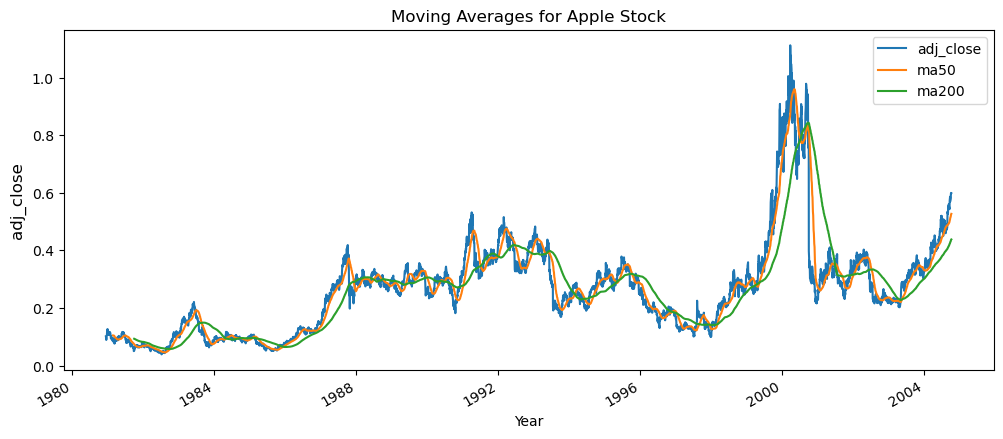

In [41]:
# Calculating the 50-day and 200-day Moving Average for Apple stock:
df_train['ma50'] = df_train['adj_close'].rolling(50).mean()
df_train['ma200'] = df_train['adj_close'].rolling(200).mean()
df_train['adj_close'].plot(figsize = (12,5))
df_train['ma50'].plot()
df_train['ma200'].plot()
plt.xlabel('Year')
plt.ylabel('adj_close', fontsize=12)
plt.title('Moving Averages for Apple Stock')
plt.legend()
plt.show()

Observations:<br>
    - Moving averages have an smoothening effect on adj_close<br>
    - 200 day moving average is smoother than moving average 50<br>
    - Higher moving average has higher lag<br>

### Daily Average Return (DAR) for Apple Stock

The daily average return for a stock is the average gain or loss that a stock has experienced over a given period, usually expressed as a percentage of the stock's price. It is calculated by dividing the total return of a stock over a period of time by the number of trading days in that period.

For example, if a stock had an adjusted close price of $ 100 on Monday and $ 102 on Tuesday, its daily return for Tuesday would be:

(102 - 100) / 100 = 0.02 = 2%

To calculate the average daily return over a period of, say, 30 trading days, you would sum the daily returns for each of the 30 days, then divide the sum by 30.

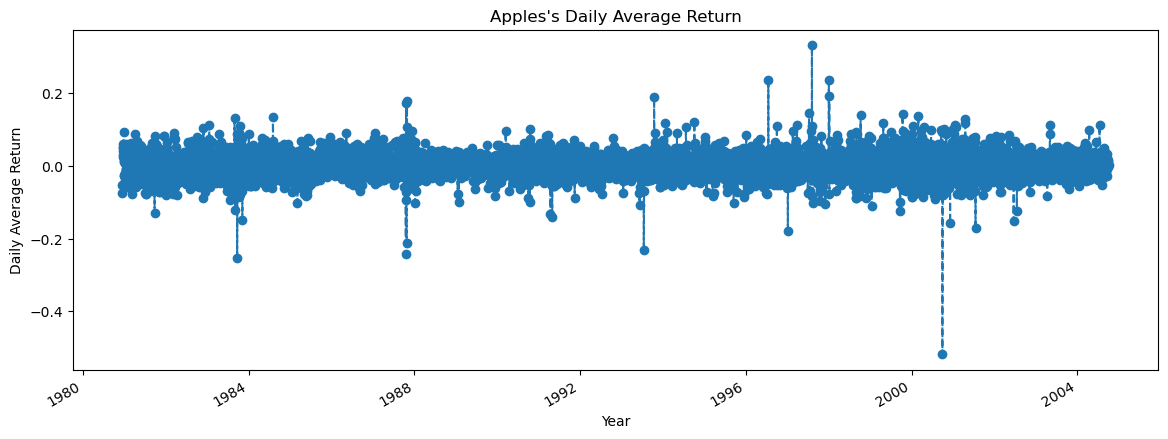

In [42]:
# Calculating the returns for Apple stock using the pct_change() function.pct means percent
df_train['dar'] = df_train['adj_close'].pct_change()
df_train['dar'].plot(figsize=(14,5),linestyle='--',marker='o')
plt.xlabel('Year')
plt.ylabel('Daily Average Return')
plt.title("Apples's Daily Average Return")
plt.show()

Average daila return for Apple stays more or less same with time, with some outliers here and there.

It would be interesting to plot an interective plot of open and close stock price using plotly.

In [43]:
# installed plotly using ----> conda install -c plotly plotly. Alternatively you can also use 'pip install plotly'
# and then 'pip install plotly --upgrade'
import plotly.express as px

In [44]:
fig = px.line(df_train, x=df_train.index, y=["open", "close"], title='Daily open & close for Apple Stocks')
fig.update_layout(title=dict(text="Daily open-close for Apple Stocks",font=dict(size=18)))
fig.show()

### Visualization of Movements of Apple stocks in terms of volume for Weekdays and by Months

For this we have to add Days (Mondays, Tuesdays etc.) and Months (Jan, Feb etc.) to our dataframe df_train. We'll do it below.

In [45]:
# adding a few more columns to our dataset -  year, month name, and weekday name
df_train['year'] = pd.DatetimeIndex(df_train['date']).year
df_train['month'] = pd.DatetimeIndex(df_train['date']).month_name()
df_train['weekday'] = pd.DatetimeIndex(df_train['date']).day_name()  # day_name is a function in pandas

In [46]:
df_train.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  ma50  ma200       dar  year     month    weekday  
date                                                                       
1980-12-12  469033600.0   NaN    NaN       NaN  1980  December     Friday  
1980-12-15  175884800.0   NaN    NaN -0.052172  1980  December     Monday  
1980-12-16  105728000.0   NaN    NaN -0.073392  1980  December    Tuesday  
1980-12-17   86441600.0   NaN    NaN  0.024749  1980  December  Wednesday  
1980-12-18   73449600.0   NaN    NaN  0.028990  1980  December   Thursday

Now let's do the plotting.

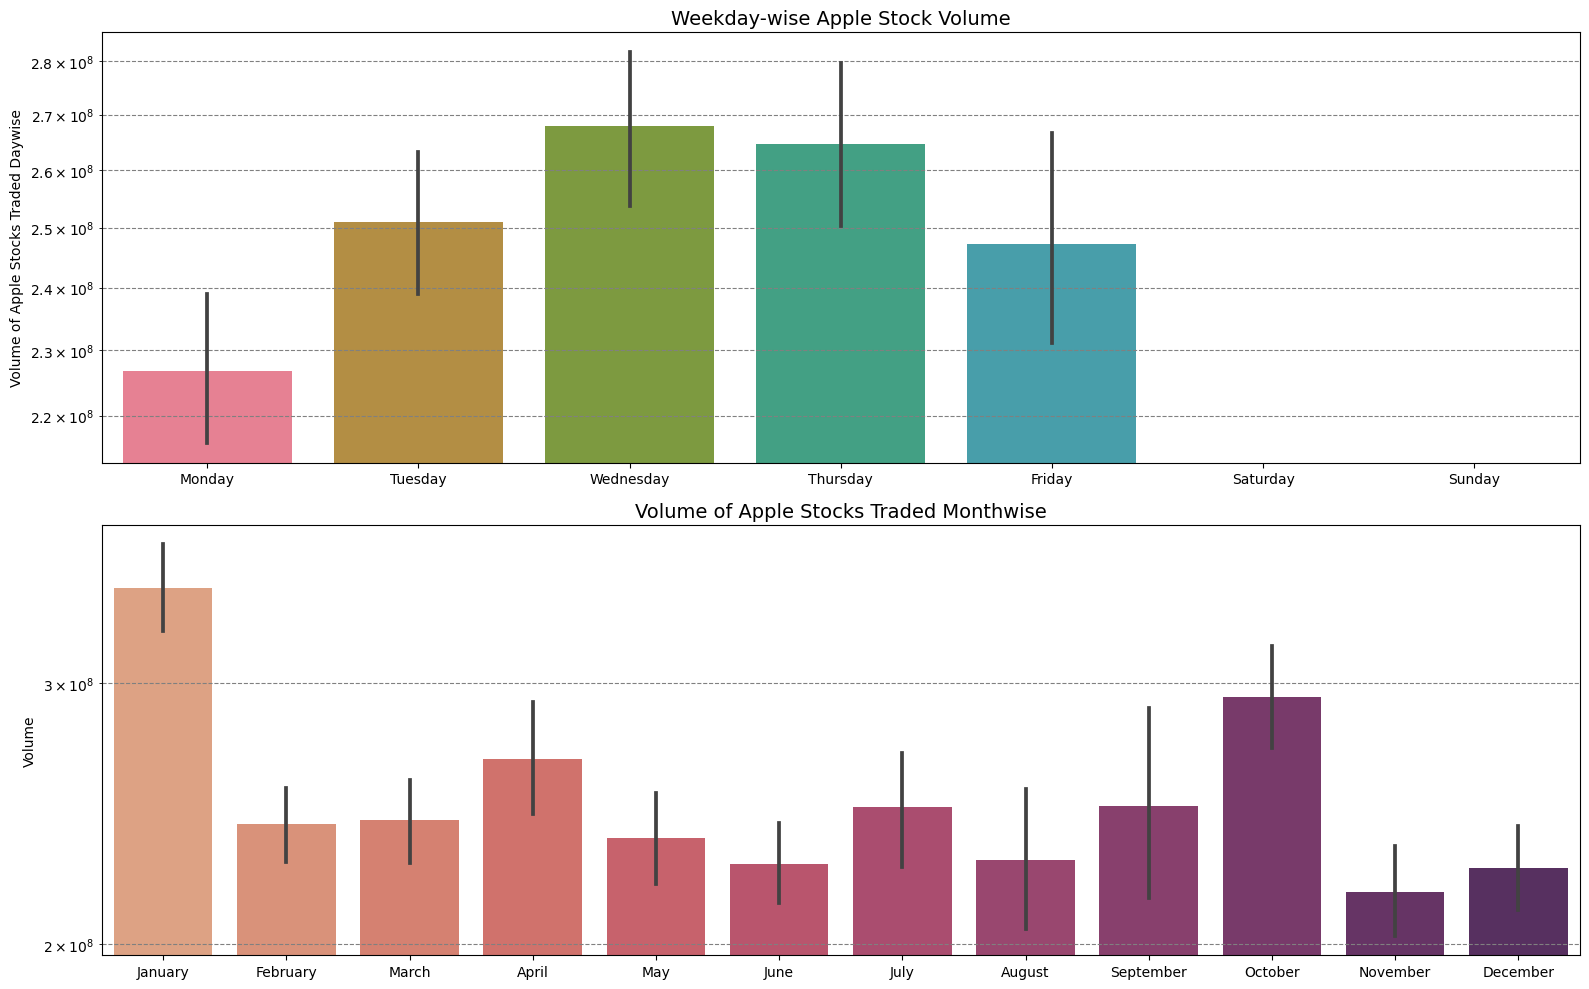

In [47]:
# Visualization of Movements of Apple stocks in terms of volume by Weekdays and by Months 
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# specifying the order of bar plots for weekdays:
order = [ "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
sns.barplot(x=df_train.weekday, y=df_train.volume, palette="husl",ax=axes[0], order =order)
axes[0].set_title("Weekday-wise Apple Stock Volume",fontsize=14)
axes[0].set_yscale("log") 
axes[0].set_ylabel("Volume of Apple Stocks Traded Daywise",fontsize=10)
axes[0].set_xlabel("",fontsize=10)
axes[0].grid(which="minor",color="grey", linestyle="--")

# specifying the order of bar plots for Months:
order2 = [ "January", "February", "March", "April", "May", "June","July", 'August', 'September', 'October', 'November', 'December']
sns.barplot(x=df_train.month, y=df_train.volume, palette="flare",ax=axes[1], order = order2)
axes[1].set_title("Volume of Apple Stocks Traded Monthwise",fontsize=14)
axes[1].set_yscale("log")
axes[1].set_ylabel("Volume",fontsize=10)
axes[1].set_xlabel("",fontsize=10)
axes[1].grid(which="minor",color="grey", linestyle="--")

plt.tight_layout()
plt.show()

Observations:<br>

- Trade volumes of Apple's stocks are highest on Wednesday and Thursday
- There are no trading on Weekends
- Monthwise, highest volume of trading takes place january and october.

### How does mean of Apples's stock on first day of a year trends over years? 

In [48]:
df_train.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  ma50  ma200       dar  year     month    weekday  
date                                                                       
1980-12-12  469033600.0   NaN    NaN       NaN  1980  December     Friday  
1980-12-15  175884800.0   NaN    NaN -0.052172  1980  December     Monday  
1980-12-16  105728000.0   NaN    NaN -0.073392  1980  December    Tuesday  
1980-12-17   86441600.0   NaN    NaN  0.024749  1980  December  Wednesday  
1980-12-18   73449600.0   NaN    NaN  0.028990  1980  December   Thursday

In [49]:
# First, create a copy of train dataset:
df_train_resample_mean = df_train.copy()
df_train_resample_mean.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  ma50  ma200       dar  year     month    weekday  
date                                                                       
1980-12-12  469033600.0   NaN    NaN       NaN  1980  December     Friday  
1980-12-15  175884800.0   NaN    NaN -0.052172  1980  December     Monday  
1980-12-16  105728000.0   NaN    NaN -0.073392  1980  December    Tuesday  
1980-12-17   86441600.0   NaN    NaN  0.024749  1980  December  Wednesday  
1980-12-18   73449600.0   NaN    NaN  0.028990  1980  December   Thursday

In [50]:
df_train_resample_mean.close.resample(rule='AS',label='right').mean()
#df_train_mean_resampled = df_train_mean.close.resample(rule='AS', label='right').mean()

date
1981-01-01    0.135903
1982-01-01    0.108531
1983-01-01    0.085459
1984-01-01    0.167274
1985-01-01    0.119651
1986-01-01    0.090233
1987-01-01    0.144913
1988-01-01    0.347751
1989-01-01    0.370884
1990-01-01    0.371953
1991-01-01    0.335373
1992-01-01    0.468701
1993-01-01    0.489309
1994-01-01    0.366310
1995-01-01    0.304291
1996-01-01    0.361966
1997-01-01    0.222495
1998-01-01    0.160418
1999-01-01    0.272900
2000-01-01    0.515805
2001-01-01    0.816283
2002-01-01    0.361061
2003-01-01    0.341776
2004-01-01    0.331156
2005-01-01    0.514367
Freq: AS-JAN, Name: close, dtype: float64

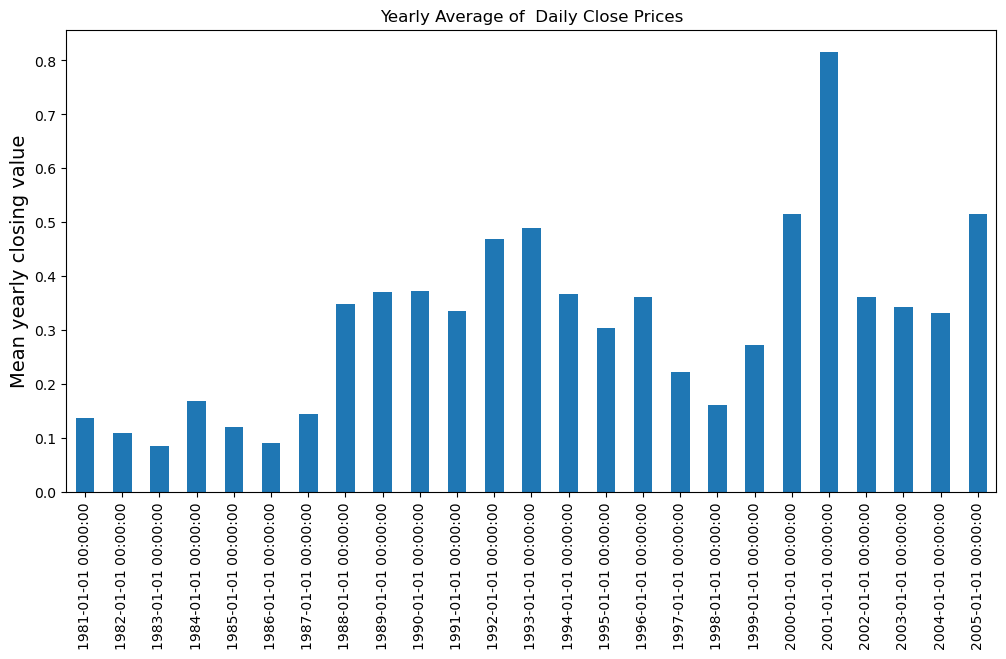

In [51]:
# Plotting a bar for the mean on start of every year 
# Below line will resample the close column of dataframe with AS (annual frequency) and get the yearly mean
ax = df_train_resample_mean.close.resample(rule='AS', label='right').mean().plot.bar(figsize=(12,6))

# setting the title for the plot:
ax.set(title='Yearly Average of  Daily Close Prices')
plt.ylabel('Mean yearly closing value',size=14)
plt.xlabel('')
plt.show()

Observation:
* Yearly average of closing prices fluctuates over years   

### Correlation matrix

In [52]:
df_train_corr = df_train.copy()
df_train_corr.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  ma50  ma200       dar  year     month    weekday  
date                                                                       
1980-12-12  469033600.0   NaN    NaN       NaN  1980  December     Friday  
1980-12-15  175884800.0   NaN    NaN -0.052172  1980  December     Monday  
1980-12-16  105728000.0   NaN    NaN -0.073392  1980  December    Tuesday  
1980-12-17   86441600.0   NaN    NaN  0.024749  1980  December  Wednesday  
1980-12-18   73449600.0   NaN    NaN  0.028990  1980  December   Thursday

In [53]:
df_train_corr = df_train_corr.drop(['ma50','ma200','dar','year','month','weekday'],axis=1)
df_train_corr.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0

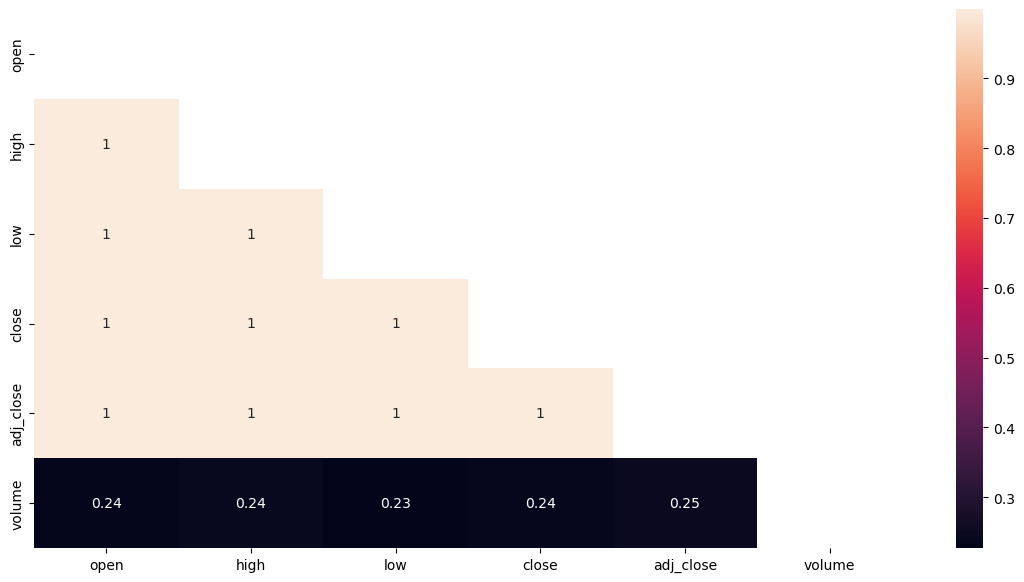

In [54]:
corrM = df_train_corr.corr()

plt.figure(figsize=(14,7))
mask = np.zeros_like(corrM, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corrM[mask] = np.nan
sns.heatmap(corrM, annot=True)
plt.show()

Above correleation matrix plot is not very insightful, as most of them have correlation coefficient of 1. We'll look into how how the differences correlate with volume.

In [55]:
df_train_corr_diff = df_train_corr.copy()
df_train_corr_diff.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0

In [56]:
# firstly, we crete a copy of the Amazon datasset:
df_train_corr_diff = df_train_corr.copy() 
#df_train_corr_diff.reset_index(inplace=True)

# Feature engineering - adding new columns to the new dataset created:
df_train_corr_diff['open-high'] = df_train_corr_diff['open']-df_train_corr_diff['high']
df_train_corr_diff['open-low'] = df_train_corr_diff['open'] - df_train_corr_diff['low']
df_train_corr_diff['open-close'] = df_train_corr_diff['open'] - df_train_corr_diff['close']
df_train_corr_diff['high-low'] = df_train_corr_diff['high'] - df_train_corr_diff['low']
df_train_corr_diff['high-close'] = df_train_corr_diff['high']-df_train_corr_diff['close']
df_train_corr_diff['close-low'] = df_train_corr_diff['close'] - df_train_corr_diff['low']



# Creating a heatmap to visualize the correlation among different Daily price columns for Amazon stocks:
df_train_corr_diff = df_train_corr_diff.drop(['open','high','low','close', 'adj_close'],axis=1)

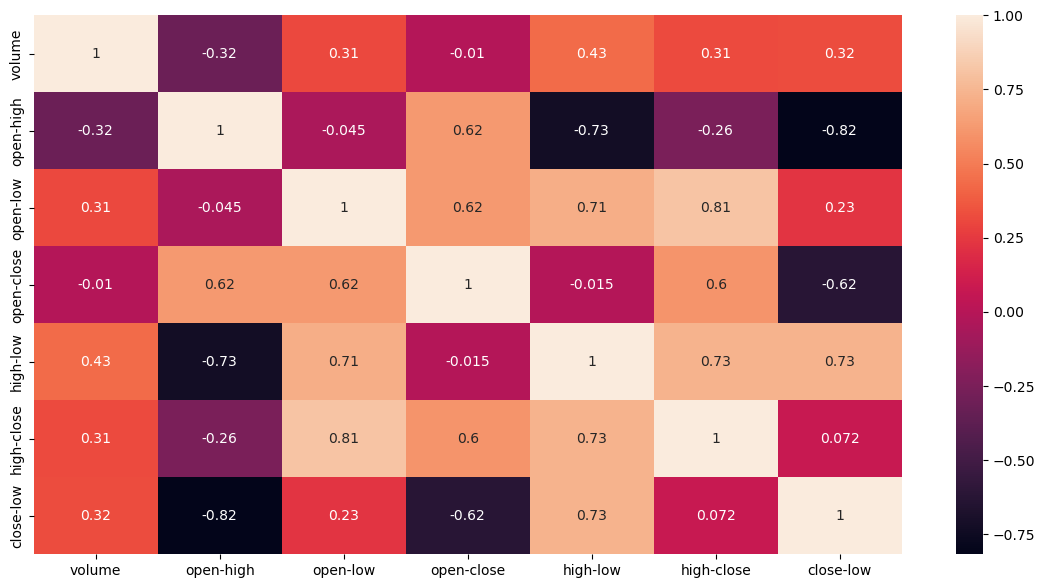

In [57]:
plt.figure(figsize=(14,7))
sns.heatmap(df_train_corr_diff.corr(),annot=True)
plt.show()

Observations:<br>

- it is more useful than the previous heatmap
- highest correlation of volume traded is with high-low. It makes sense because higher is the change in stock price, more activities in the market.

Now we'll do some advanced technical analysis:
- From now on we'll use only date and adjusted close for analysis. <br>

The **adjusted close** is used in stock market analysis as a more accurate representation of the true price of a stock at the end of a trading day. This is because the adjusted close takes into account various corporate actions, such as stock splits, dividends, and rights issues, that can impact the price of a stock.

When a company takes one of these actions, the price of its stock may change, but the change may not reflect the true underlying value of the company or its stock. The adjusted close adjusts the close price of a stock to account for these corporate actions, giving a more accurate representation of the true value of the stock.

For example, consider a stock that has a split, where each share is split into two shares. The number of shares in the market doubles, but the price of each share is halved. The adjusted close adjusts the close price of the stock to account for the split, so that it accurately reflects the true value of the stock before and after the split.

By using the adjusted close in stock market analysis, analysts and investors can better understand the price trends and patterns of a stock over time, and make more informed investment decisions.


Thus from now on, I have only two columns: date and adjusted close.

In [58]:
df_train = df_train.drop(['ma50','ma200','dar','year','month','weekday'],axis=1)
df_train.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0

### Testing for Stationarity

Time series analysis can be done on a dataset only if it is **stationary**. 

Stationarity is a requirement for time series analysis because a stationary time series is one whose statistical properties such as mean, variance, and autocovariance do not change over time. In other words, the values in a stationary time series are not dependent on the time at which they were recorded.

Time series analysis techniques such as forecasting, decomposition, and hypothesis testing all make assumptions about the statistical properties of the data. When these assumptions are not met, such as when the data is non-stationary, the results of the analysis may be misleading or incorrect. By ensuring that the data is stationary, these assumptions are satisfied and the results of the time series analysis are more reliable. Additionally, many time series models, such as ARIMA, require stationary data in order to be fit correctly.

A non-stationary time series dataset, however, can be made stationary through a process called "differencing". Differencing involves subtracting the value of the time series at a given point in time from the value of the time series at the previous time point. This can help to remove trends and seasonality from the time series and make it more stationary. There are other techniques for making a non-stationary time series stationary as well, including transforming the data (such as taking the log or square root), removing the trend and seasonality through modeling and removing, and using moving averages or exponential smoothing.

It's important to note that the choice of transformation or technique for making a non-stationary time series stationary will depend on the specific properties of the data and the research questions being addressed. It may also be necessary to perform multiple rounds of differencing or transformations in order to achieve stationarity.

**Testing for Stationarity** in a time series can be done using one or more of the following statistical methods:

- Augmented Dicky-Fuller (ADF) Test
- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test


The ***Augmented Dickey-Fuller (ADF) test** is a hypothesis test that tests the null hypothesis that a time series is non-stationary. If the **p-value** of the ADF test is less than a predetermined level of significance (such as 0.05), the null hypothesis is rejected and it is concluded that the time series is stationary.

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test** is a similar hypothesis test that tests the null hypothesis that a time series is stationary. If the p-value of the KPSS test is greater than the level of significance, the null hypothesis is accepted and it is concluded that the time series is non-stationary.

It is also common to visually inspect the time series data, such as by plotting the data and observing if there is any clear **trend** or **seasonality**, or by plotting the **rolling mean** and **standard deviation** to see if they are stable over time. Additionally, the **autocorrelation plot (ACF)** and **partial autocorrelation plot (PACF)** of the time series can provide insight into its stationarity.

In general, it's a good practice to use both statistical tests and visual inspection to determine the stationarity of a time series.

Ref:<br> 
[How to Check if Time Series Data is Stationary](https://machinelearningmastery.com/time-series-data-stationary-python/)

#### Visualization: adjusted close and monthly mean

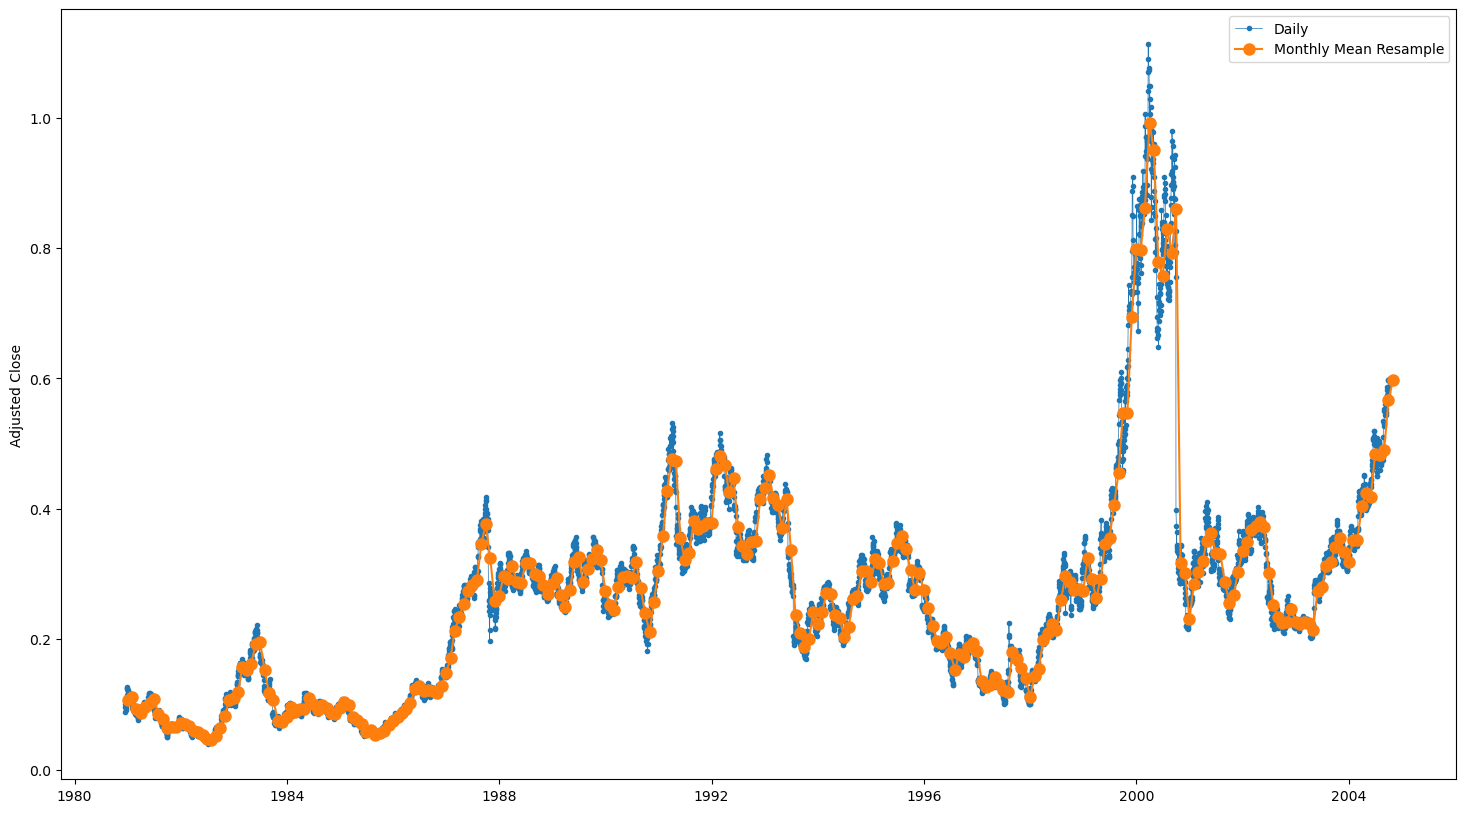

In [59]:
# Visualizing the Daily Adjusted Close and the Monthly Average resampled data
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(df_train['adj_close'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df_train['adj_close'].resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Adjusted Close')
ax.legend()
plt.show()

* Both daily and monthly mean follow the same macroscopic trend. 
* no clear trend or seasonality is there.

#### visualization: Rolling or, moving Statistics

Rolling statistics, also known as moving statistics, are calculations of summary statistics that are computed over a rolling window of time in a time series. The rolling window is a fixed-size sliding window that moves through the time series, and the summary statistics are calculated over the data within the window at each position of the window.

In time series analysis, rolling statistics are often used to assess the stability of the mean and variance of a time series over time. For example, the rolling mean and rolling standard deviation of a time series can be computed and plotted over time to visualize how the mean and variance change over time.

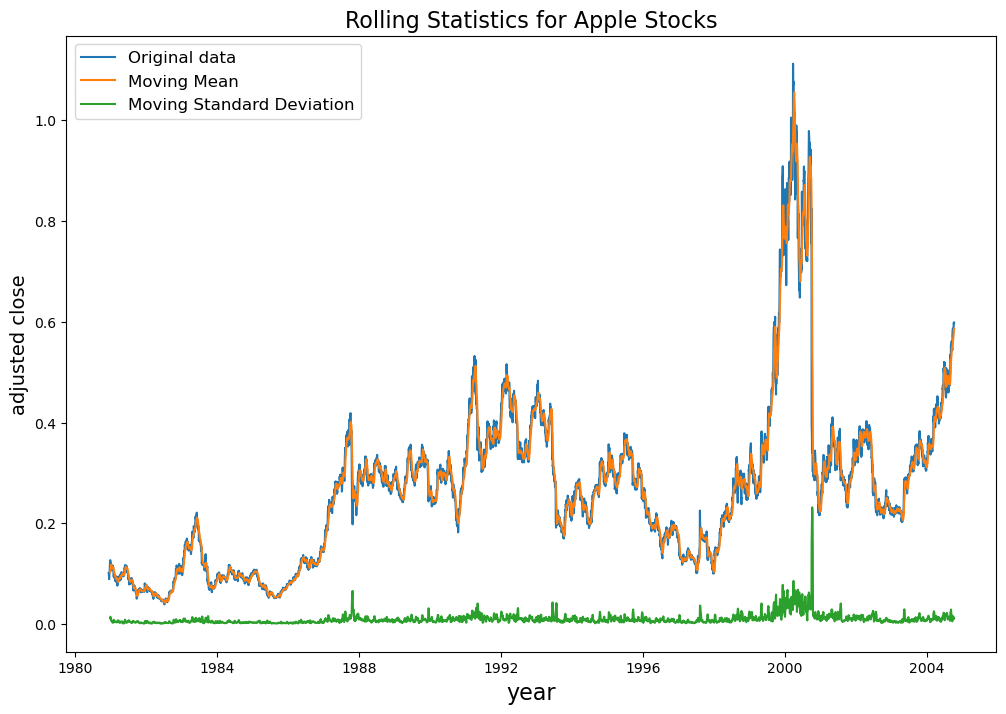

In [60]:
# Determining the moving statistics
df_train_roll = df_train['adj_close']

# calculating the moving mean and standard deviation with window size of 12 days 
roll_mean = df_train_roll.rolling(10).mean() 
roll_std = df_train_roll.rolling(10).std()

# plotting the moving statistics alongwith the original data: 
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_train['adj_close'], label= 'Original data')
ax.plot(roll_mean, label='Moving Mean')
ax.plot(roll_std, label='Moving Standard Deviation')
plt.title('Rolling Statistics for Apple Stocks', fontsize=16)
ax.set_ylabel('adjusted close', fontsize=14)
ax.set_xlabel('year', fontsize=16)
ax.legend(fontsize=12)
plt.show()

**Observations:**<br>

- Mean follows the trend of original data<br>
- Mean clearly doesn't reamin constant and fluctuates with time, suggesting non-stationarity<br>
- Standard deviation remains more or less constant with some noise till about 1999 but then it increases and even has a big jump. So std. dev. is not constant as well, suggesting non-stationarity.<br>
    
**Visual inspection** suggests that our data is not stationary.<br>

To confirm it further, I'll perform ADF test mentioned earlier now.

### ADF Test

To confirm non-stationarity of data, let's perform **ADF test** mentioned earlier. 

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series dataset is stationary. The null hypothesis of the test is that the time series has a unit root (i.e., it is non-stationary), and the alternative hypothesis is that the time series is stationary.

The ADF test works by testing the correlation between the time series and its first differences. If the correlation is low, it indicates that the time series is stationary. The ADF test statistic is calculated as the t-statistic of the estimated coefficient on the first difference term in a regression model. If the calculated ADF test statistic is smaller than the critical value, the null hypothesis can be rejected and the conclusion is that the time series is stationary.

The ADF test is widely used in time series analysis and is a widely accepted method for testing for stationarity. However, it should be noted that the ADF test is a univariate test, meaning that it only considers one time series at a time, and it may not always be appropriate for all datasets.

In [61]:
# Running the adfuller() function on adj_close of Apple stock

#first import adfuller
from statsmodels.tsa.stattools import adfuller


result = adfuller(df_train['adj_close'])

# Printing the test statistic, the p-value and the critical values:
# manually specifying the statistics using a for loop:
output = pd.Series(result[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in result[4].items():
    output['critical value (%s)'%key] =  values
print(output)

# Printing a statement about accepting or rejecting the Null hypothesis by comparing the p-value with the critical values:
if output[1] <= 0.05:
    print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("Weak evidence against null hypothesis, indicating Data is non-stationary.")

Test Statistics                  -2.226675
p-value                           0.196707
No. of lags used                 32.000000
Number of observations used    5976.000000
critical value (1%)              -3.431445
critical value (5%)              -2.862024
critical value (10%)             -2.567028
dtype: float64
Weak evidence against null hypothesis, indicating Data is non-stationary.


ADF test above is performed using the adfuller() function from the statsmodels library. The result object of the ADF test is a tuple with following key elements:

    Zeroth element - Test statistic (the more negative this number is, the more likely that data is stationary)
    Next element - p-value (if p-value < 0.05, we reject the H0 and assume our time series to be stationary)
    Last element - a Python Dictionary with critical values of the test statistic equating to different p-values

Since p value in above test is larger than 0.05, it suggests that our data is **non-stationary**.

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test 

Now we'll perform the KPSS test to confirm that our data is non-stationary.

In [62]:
#import kpss function from statsmodels.tsa.stattools
from statsmodels.tsa.stattools import kpss

In [63]:
#write a function for kpss test
def kpss_test(df, significance=0.05):
    result = kpss(df, regression='c')
    p_value = result[1]
    if p_value < significance:
        print(f'Series is NOT Stationary with p-value {p_value}')
    else:
        print(f'Series is  Stationary with p-value {p_value}')

In [64]:
kpss_test(df_train['adj_close'])

Series is NOT Stationary with p-value 0.01


Thus, visualization, ADF and KPSS, all tests have confirmed that our dataset is non-stationary. This means we can't use time series analysis on this dataset. Now, we have to make our data stationary.

There are several methods to make a non-stationary time series stationary, including:

- **Detrending**: It is used to remove the trend component from the time series. Detrending can be performed in various ways, e.g. subtracting the mean or median value from each observation in the time series

- **Differencing**: This involves subtracting the value of each observation from the value of the previous observation. This can be repeated multiple times to achieve stationarity.

- **Transformation**: This involves transforming the data to make it more stationary, such as taking the log or square root of the data.

- **Decomposition**: This involves breaking down the time series into its component parts, such as trend, seasonality, and residuals, and then removing the non-stationary component.

- **Seasonal adjustment**: This involves removing the seasonality component from the data to make it stationary.

- **ARIMA modeling**: This involves modeling the time series using an AutoRegressive Integrated Moving Average (ARIMA) model, which allows for differencing, transformation, and seasonal adjustment to be performed in a single step.

The appropriate method to make a non-stationary time series stationary depends on the specific characteristics of the data. It's best to try different methods and compare the results to determine the best approach.

## Making the Data Stationary

### Detrending
The idea here is to remove the underlying trend in the data by first subtracting moving mean from the data points and then dividing the results of subtraction with moving standard deviation of the data. It makes the data to have mean of zero and standard deviation of 1. 

In [65]:
df_train.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0

In [66]:
# Detrending the data:
df_train_detrend = df_train.copy()
df_train_detrend['adj_close'] =  (df_train['adj_close'] - \
                                  df_train['adj_close'].rolling(10).mean()) / df_train['adj_close'].rolling(10).std()

In [67]:
df_train_detrend.head(20)

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348        NaN   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652        NaN   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723        NaN   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513        NaN   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862        NaN   
1980-12-19 1980-12-19  0.126116  0.126674  0.126116  0.126116        NaN   
1980-12-22 1980-12-22  0.132254  0.132813  0.132254  0.132254        NaN   
1980-12-23 1980-12-23  0.137835  0.138393  0.137835  0.137835        NaN   
1980-12-24 1980-12-24  0.145089  0.145647  0.145089  0.145089        NaN   
1980-12-26 1980-12-26  0.158482  0.159040  0.158482  0.158482   2.022452   
1980-12-29 1980-12-29  0.160714  0.161272  0.160714  0.160714   1.610300   
1980-12-30 1980-12-30  0.157366  0.157366  0.156808  0.156808   1.115612   
1980-12-31 1980-12-31  0.152902  0.152902  0.152344  0.152344   0.711773   
1981-01-02 1981-01-02  0.154018  0.155134  0.154018  0.154018   0.663183   
1981-01-05 1981-01-05  0.151228  0.151228  0.150670  0.150670   0.275025   
1981-01-06 1981-01-06  0.144531  0.144531  0.143973  0.143973  -0.566301   
1981-01-07 1981-01-07  0.138393  0.138393  0.137835  0.137835  -1.449222   
1981-01-08 1981-01-08  0.135603  0.135603  0.135045  0.135045  -1.657028   
1981-01-09 1981-01-09  0.142299  0.142857  0.142299  0.142299  -0.775573   
1981-01-12 1981-01-12  0.142299  0.142299  0.141183  0.141183  -0.733511   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0  
1980-12-19   48630400.0  
1980-12-22   37363200.0  
1980-12-23   46950400.0  
1980-12-24   48003200.0  
1980-12-26   55574400.0  
1980-12-29   93161600.0  
1980-12-30   68880000.0  
1980-12-31   35750400.0  
1981-01-02   21660800.0  
1981-01-05   35728000.0  
1981-01-06   45158400.0  
1981-01-07   55686400.0  
1981-01-08   39827200.0  
1981-01-09   21504000.0  
1981-01-12   23699200.0

In [68]:
# function for performing adf test
def adf_test(df, significance=0.05):
    adf_result = adfuller(df['adj_close'].dropna())
    output = pd.Series(adf_result[0:4], index=['Test Statistics', 'p-value', 'No. of Lags Used',\
                                               'Number of Observations Used'])
    for key, value in result[4].items():
        output['Critical Value (%s)' % key] = value
    if output['p-value'] <= significance:
        print('Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.')
    else:
        print('Weak evidence against the null hypothesis (Ho), indicating data is non-stationary.')
    return output

In [69]:
adf_test(df_train_detrend)

Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.


Test Statistics                 -18.868682
p-value                           0.000000
No. of Lags Used                 10.000000
Number of Observations Used    5989.000000
Critical Value (1%)              -3.431445
Critical Value (5%)              -2.862024
Critical Value (10%)             -2.567028
dtype: float64

We already see from the ADF test that our dataset after detrend is stationary. We'll visualize the rolling statistics now.

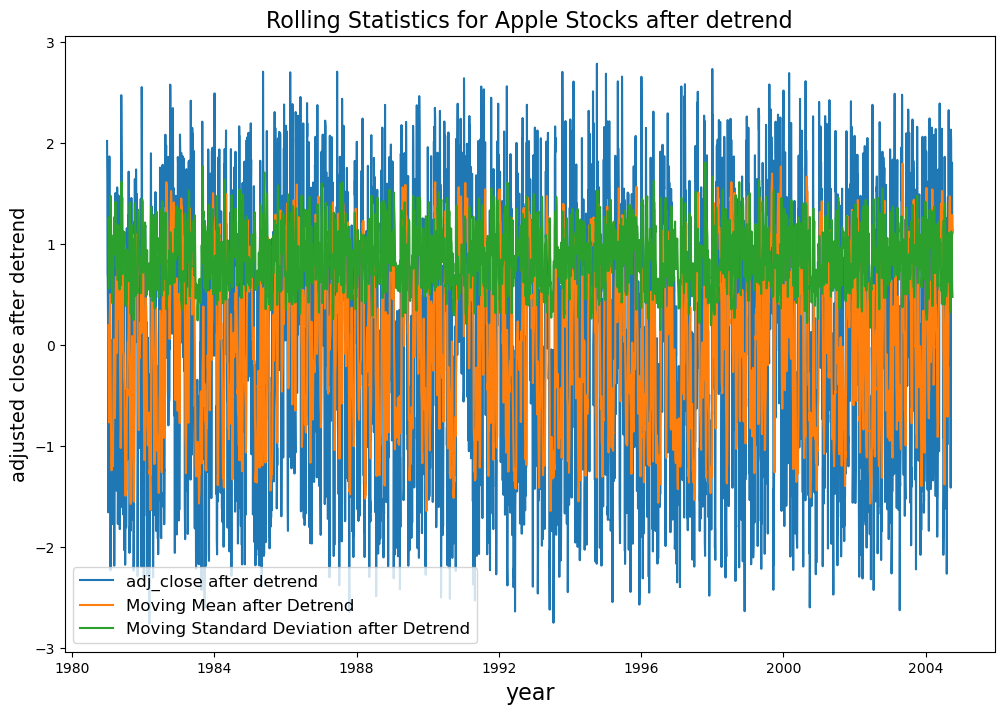

In [70]:
# Determining the moving statistics
df_train_detrend_roll = df_train_detrend['adj_close']

# calculating the moving mean and standard deviation with window size of 12 days 
roll_mean = df_train_detrend_roll.rolling(10).mean() 
roll_std = df_train_detrend_roll.rolling(10).std()

# plotting the moving statistics alongwith the original data: 
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_train_detrend['adj_close'], label= 'adj_close after detrend')
ax.plot(roll_mean, label='Moving Mean after Detrend')
ax.plot(roll_std, label='Moving Standard Deviation after Detrend')
plt.title('Rolling Statistics for Apple Stocks after detrend', fontsize=16)
ax.set_ylabel('adjusted close after detrend', fontsize=14)
ax.set_xlabel('year', fontsize=16)
ax.legend(fontsize=12)
plt.show()

**Observations:**<br>
* adjusted close after detrend has zero mean<br>
* moving mean after detrend is averaged at zero<br>
* moving std. dev. after detrend is averaged around 1<br>

### Differencing

Another common method used for stationarizing a time-series is **differencing**. It involves subtracting the value of a time series at a particular time step with its value at a previous time step. The resulting difference series is used instead of the original time series for further analysis.

The purpose of differencing is to remove the trend and seasonality from a time series.

Differencing can be performed multiple times to remove higher-order trends and seasonality. For example, the difference of a difference series (known as second-order differencing) can be taken to remove second-order trends.

One has to be careful not to over-difference a time series, because, an over-differenced series may still be stationary but would affect the model parameters.

Therefoe, **Optimal order for Differencing** is defined as minimum differencing order required to get a near-stationary series with a defined mean and for which the **ACF** plot quickly reaches zero.

In [71]:
## First Order of Differencing -
# Taking the first order difference of Apple stock data by  dropping the NaN
# Calculating the first difference of the time series:
df_train_diff = df_train.copy()
df_train_diff['adj_close'] = df_train['adj_close'].diff().dropna()

In [72]:
adf_test(df_train_diff)

Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data is stationary.


Test Statistics               -1.512135e+01
p-value                        7.452270e-28
No. of Lags Used               3.100000e+01
Number of Observations Used    5.976000e+03
Critical Value (1%)           -3.431445e+00
Critical Value (5%)           -2.862024e+00
Critical Value (10%)          -2.567028e+00
dtype: float64

## ACF and PACF Plots

Now we'll look at the ACF and PACF plots.

**ACF** and **PACF** are plots used in time series analysis to understand the **autocorrelation structure** of a time series.

ACF (Auto-Correlation Function) plot shows the correlation between the time series and its lagged (delayed) values. The plot shows the correlation between the time series and lagged values of itself, where a strong positive correlation indicates a strong relationship between the series and its lagged values.

PACF (Partial Auto-Correlation Function) plot shows the direct relationship between a time series and its lagged values, after controlling for the relationship between the time series and all its intermediate lagged values. The plot shows the correlation between the time series and each of its lagged values, after controlling for the influence of all other lagged values.

Both ACF and PACF plots are used:<br>

* to identify the appropriate order of differencing and the number of autoregressive (AR) and moving average (MA) terms in time series models such as ARIMA. 
* to determine the presence of autocorrelation and partial autocorrelation, which can be used to make informed decisions about modeling the time series.

A complete zero Autocorrelation on ACF means that there is no significant autocorrelation between lagged values of the series, This means that the value of the time series at any point in time is not significantly related to its value at prior time points. In other words, the presence of a trend or seasonality in the time series is not strong enough to produce a non-zero ACF. This information can be useful in identifying the appropriate time series model to use for forecasting, as it suggests that a simple model such as a random walk or white noise model might be appropriate, rather than a more complex model that assumes a strong autocorrelation.

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

width = 12
height = 4

# write a function for plotting ACF and PACF
def plot_acf_pacf(df, column, figsize=(width, 3*height), title=None):
    ts = df[column].dropna()
    
    fig = plt.figure(figsize=figsize)
    if title:
        fig.suptitle(title, fontsize=16, y=1)
    
    ax1 = fig.add_subplot(311)
    ax1.plot(ts)
    ax1.set_title('Adjusted Close of Time Series')

    # Plot the autocorrelation function ACF
    ax2 = fig.add_subplot(312)
    fig = plot_acf(ts, lags=40, ax=ax2)
    ax2.set_title('Autocorrelation Function (ACF)')

    # Plot the partial autocorrelation function
    ax3 = fig.add_subplot(313)
    fig = plot_pacf(ts, lags=40, method = 'ywm', ax=ax3)
    ax3.set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

### On originial train data i.e. before differencing or detrending

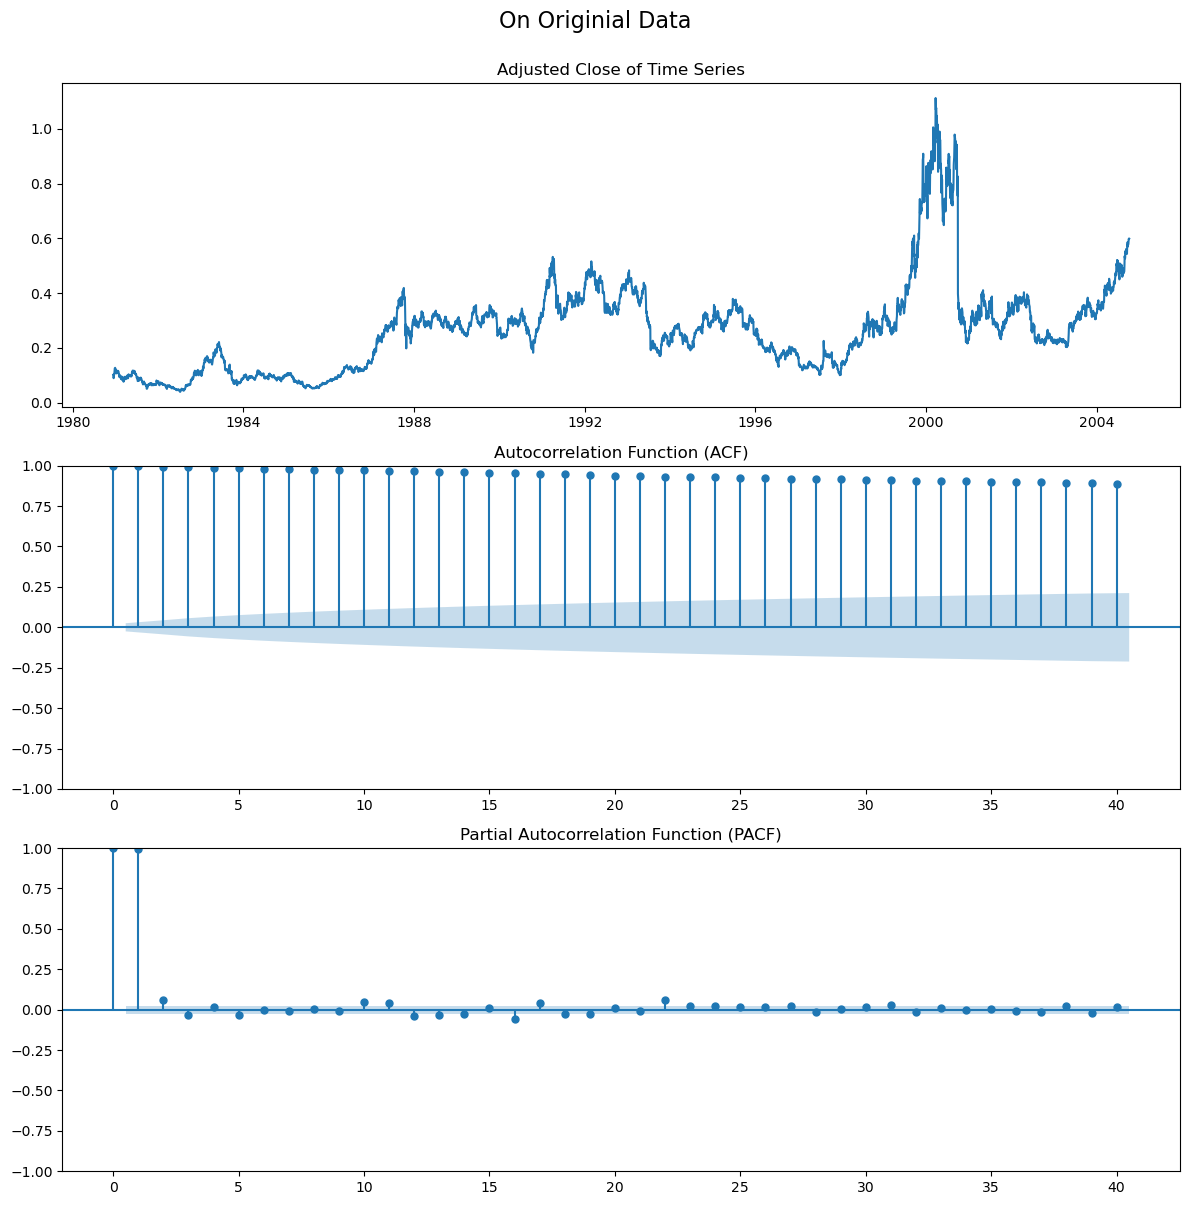

In [74]:
plot_acf_pacf(df_train, 'adj_close', title='On Originial Data')

**Observations:**<br>

**ACF**<br>
* ACF is 1 at the first lag and then decreases very slowly.

* It indicates that there is a strong positive correlation between the observation and its first lag, and the correlation gradually decreases as the lag increases. Thus, there may be a slowly-decaying relationship between the observations, possibly due to a slow-moving underlying trend or seasonality in the data.   

* The shaded part in the ACF plot represents the confidence interval of the sample autocorrelation. It provides a visual indication of the uncertainty around the estimated autocorrelation values.

Typically, the shaded region is calculated based on the assumption that the underlying time series is a random process, and it is constructed as a function of the sample size and the level of significance (often set to 0.05). If the autocorrelation values outside the shaded region are significantly different from zero, it suggests that there is a meaningful relationship between the observation and its lagged values.

The shaded part in an ACF plot can be useful in guiding the interpretation of the plot, as it provides a way to assess the statistical significance of the estimated autocorrelations. However, it's important to remember that the shaded region is based on assumptions about the underlying process and the sample size, and it may not always be an accurate reflection of the true uncertainty in the autocorrelation estimates.

**PACF**<br>

* PACF is close to 1 for the first maybe 2 lags, but then close to zero for higher lags. It suggests that the first 2 lags have a strong relationship with the current observation, while the higher lags have little to no relationship. This pattern often indicates an AR(2) model, where the current observation is a linear combination of the 2 previous observations. In other words, the first 2 lags are the significant lags in the time series.

* It's important to note that the interpretation of PACF plots can be influenced by the stationarity of the time series, and it's recommended to check the stationarity of the data before analyzing the PACF plot. Additionally, the choice of which lags to include in a time series model should also be guided by other methods, such as the Akaike information criterion (AIC) or Bayesian information criterion (BIC).



We need to keep in mind that ACF and PACF for non-stationary data may be misleading and our original data, as lready seen previously, is non-stationary. However these plots are made as an exercise and how does it look and what can be interpreted.

### On train data after detrending

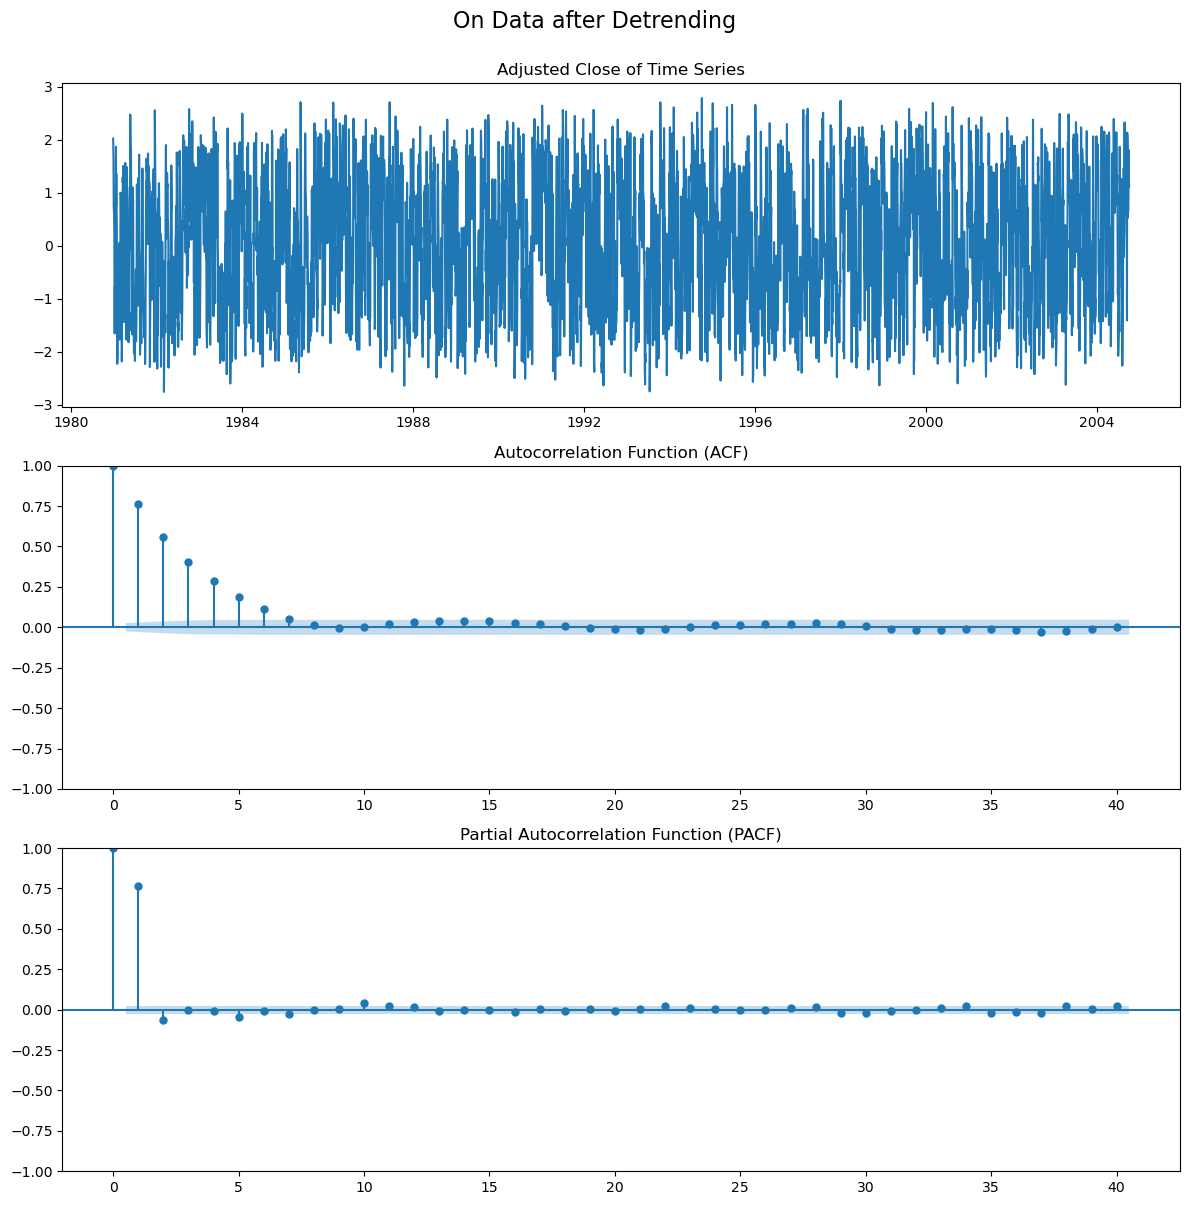

In [75]:
plot_acf_pacf(df_train_detrend, 'adj_close', title='On Data after Detrending')

**Observations**<br>

* ACF and PACF decreases rapidly compared to original data

### On dataset after differencing

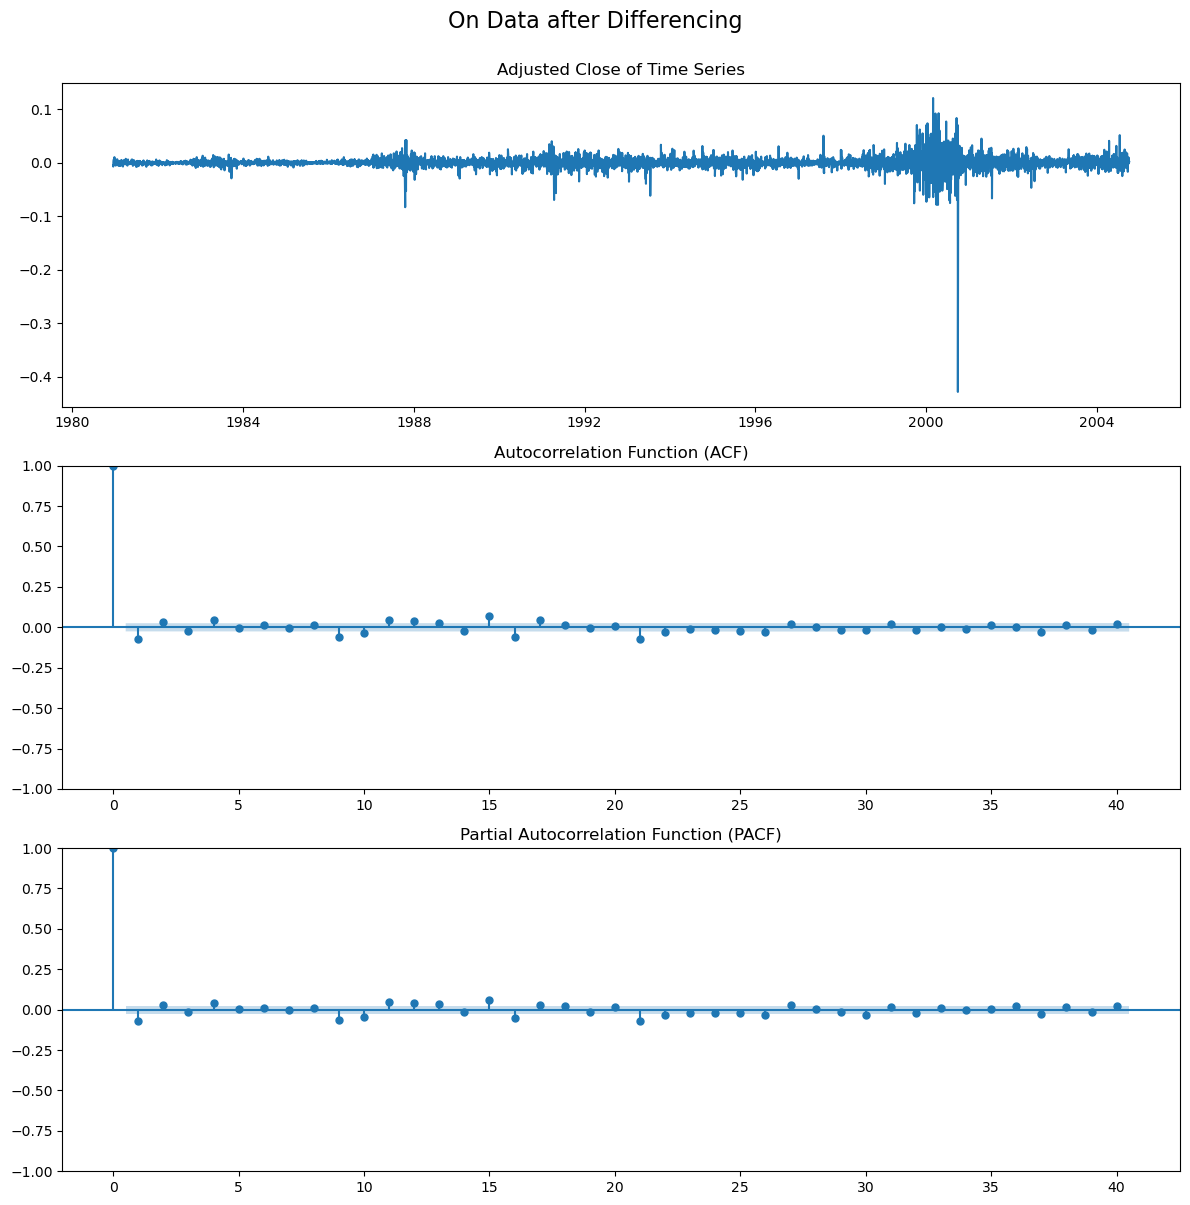

In [76]:
plot_acf_pacf(df_train_diff, 'adj_close', title='On Data after Differencing')

**Observations**:<br>

**ACF**<br>
* ACF is 1 for first lag, but then zero afterwards
* * A zero autocorrelation means that the value of the time series at any time step is not related to its value at any previous time step.

**PACF**
* PACF is 1 for first lag, but then zero afterwards
* a PACF plot that is zero, except for one jump at zero, suggests that the time series is likely to be an autoregressive time series with a strong dependence on its past value, and an AR(1) model may be a suitable choice for modeling the time series.

# 1. Seasonal ARIMA (SARIMA) model

In [77]:
df_train.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0

We'll use only the date and adj_close column for this training.

In [78]:
drop_Features = ['open', 'high','low','close','volume']
df_train_sarima = df_train.drop(axis=1,labels=drop_Features)
df_train_sarima.head()

date  adj_close
date                            
1980-12-12 1980-12-12   0.101261
1980-12-15 1980-12-15   0.095978
1980-12-16 1980-12-16   0.088934
1980-12-17 1980-12-17   0.091135
1980-12-18 1980-12-18   0.093777

In [79]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
df_train_sarima_mean = df_train_sarima['adj_close'].resample('M').mean()
df_train_sarima_mean.head()

date
1980-12-31    0.107222
1981-01-31    0.111492
1981-02-28    0.093012
1981-03-31    0.087473
1981-04-30    0.095894
Freq: M, Name: adj_close, dtype: float64

In [80]:
train = df_train_sarima_mean.to_frame()
train     

adj_close
date                 
1980-12-31   0.107222
1981-01-31   0.111492
1981-02-28   0.093012
1981-03-31   0.087473
1981-04-30   0.095894
...               ...
2004-06-30   0.483484
2004-07-31   0.482823
2004-08-31   0.489915
2004-09-30   0.566099
2004-10-31   0.597645

[287 rows x 1 columns]

In [81]:
train.head(2)

adj_close
date                 
1980-12-31   0.107222
1981-01-31   0.111492

Do the same feature engineering for df_test

In [82]:
df_val.head()

date      open      high       low     close  adj_close  \
date                                                                       
2004-10-05 2004-10-05  0.688571  0.708393  0.685714  0.703036   0.607521   
2004-10-06 2004-10-06  0.705357  0.727857  0.704821  0.725714   0.627118   
2004-10-07 2004-10-07  0.723929  0.730893  0.704643  0.707500   0.611378   
2004-10-08 2004-10-08  0.706429  0.710179  0.693571  0.697500   0.602737   
2004-10-11 2004-10-11  0.692857  0.697500  0.682143  0.689107   0.595485   

                 volume  
date                     
2004-10-05  406162400.0  
2004-10-06  446303200.0  
2004-10-07  426148800.0  
2004-10-08  359228800.0  
2004-10-11  323870400.0

In [83]:
df_val_sarima = df_val.drop(axis=1,labels=drop_Features)
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
df_val_sarima_mean = df_val_sarima['adj_close'].resample('M').mean()
val = df_val_sarima_mean.to_frame()
val 

adj_close
date                 
2004-10-31   0.693748
2004-11-30   0.886742
2004-12-31   0.995282
2005-01-31   1.068269
2005-02-28   1.292075
...               ...
2012-05-31  17.427008
2012-06-30  17.732209
2012-07-31  18.550233
2012-08-31  19.898839
2012-09-30  20.901704

[96 rows x 1 columns]

In [84]:
len(train), len(val)

(287, 96)

Carrying out Grid Search to Select Parameters especially for Seasonal Component of the Time Series .

Parameters for Series already indicate Non-Seasonality Part with Order (1,1,1).

AR(1) derived by the PACF plot

MA(1) derived by the ACF Plot

Differencing(1) derived by differencing and observing stationarity.

## Hyper Parameter Tuning for Model Order

In [86]:
df_full_train.head()

date      open      high       low     close  adj_close  \
date                                                                       
1980-12-12 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.101261   
1980-12-15 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095978   
1980-12-16 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088934   
1980-12-17 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.091135   
1980-12-18 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093777   

                 volume  
date                     
1980-12-12  469033600.0  
1980-12-15  175884800.0  
1980-12-16  105728000.0  
1980-12-17   86441600.0  
1980-12-18   73449600.0

In [87]:
#dropping other features
drop_Features = ['open', 'high','low','close','volume']
df_train_sarima = df_train.drop(axis=1,labels=drop_Features)
df_val_sarima = df_val.drop(axis=1,labels=drop_Features)
df_test_sarima = df_test.drop(axis=1,labels=drop_Features)
df_full_train_sarima = df_full_train.drop(axis=1,labels=drop_Features)
df_val_sarima.head()

date  adj_close
date                            
2004-10-05 2004-10-05   0.607521
2004-10-06 2004-10-06   0.627118
2004-10-07 2004-10-07   0.611378
2004-10-08 2004-10-08   0.602737
2004-10-11 2004-10-11   0.595485

In [88]:
##Resample Data to Monthly instead of Daily by Aggregating Using Mean
df_train_sarima_mean = df_train_sarima['adj_close'].resample('M').mean()
df_test_sarima_mean = df_test_sarima['adj_close'].resample('M').mean()
df_val_sarima_mean = df_val_sarima['adj_close'].resample('M').mean()
df_full_train_sarima_mean = df_full_train_sarima['adj_close'].resample('M').mean()
df_train_sarima_mean.head()

date
1980-12-31    0.107222
1981-01-31    0.111492
1981-02-28    0.093012
1981-03-31    0.087473
1981-04-30    0.095894
Freq: M, Name: adj_close, dtype: float64

In [89]:
#convert series object to a dataframe with a single columns
train = df_train_sarima_mean.to_frame()
test = df_test_sarima_mean.to_frame()
val = df_val_sarima_mean.to_frame()
full_train = df_full_train_sarima_mean.to_frame()

In [90]:
type(full_train)

pandas.core.frame.DataFrame

In [91]:
full_train.columns

Index(['adj_close'], dtype='object')

In [92]:
import statsmodels.api as sm

In [93]:
val.head()

adj_close
date                 
2004-10-31   0.693748
2004-11-30   0.886742
2004-12-31   0.995282
2005-01-31   1.068269
2005-02-28   1.292075

In [94]:
full_train.head()

adj_close
date                 
1980-12-31   0.107222
1981-01-31   0.111492
1981-02-28   0.093012
1981-03-31   0.087473
1981-04-30   0.095894

In [95]:
#create an instance of SARIMA model
model = sm.tsa.statespace.SARIMAX(full_train['adj_close'], order=(1,1,1), seasonal_order=(2,2,0,12), \
                                   enforce_stationarity=False, enforce_invertibility=False)


In [96]:
# fit model to the data using fit method
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34326D-01    |proj g|=  9.76176D-01


 This problem is unconstrained.



At iterate    5    f=  2.91561D-01    |proj g|=  2.06400D-02

At iterate   10    f=  2.90599D-01    |proj g|=  3.00203D-02

At iterate   15    f=  2.90455D-01    |proj g|=  4.00989D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     29      1     0     0   5.400D-05   2.905D-01
  F =  0.29045461151859187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [97]:
# use model_fit object to make predictions using predict method
prediction_test = model_fit.predict(start='2012-09-30',end='2020-09-30')

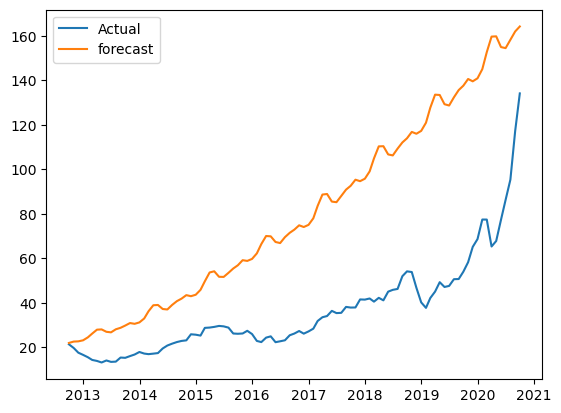

In [98]:
# Plot the DataFrame column and the Series in one plot
plt.plot(test['adj_close'], label='Actual')
plt.plot(prediction_test, label='forecast')
plt.legend()
plt.show()

**References**:

1. [Introduction to the Fundamentals of Time Series Data and Analysis](https://www.aptech.com/blog/introduction-to-the-fundamentals-of-time-series-data-and-analysis/)
2. [Time Series Modelling & Stock Forecasting in Python](https://github.com/sukritishuk/ML_ZoomCamp_Article)
3. [Working with Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)
5. [Interpreting ACF and PACF Plots for Time Series Forecasting](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)
6. 
2. [A modern Time Series tutorial](https://www.kaggle.com/code/rohanrao/a-modern-time-series-tutorial)